# This notebook is for analyzing coalescence times
I use the coalescence_grid object to generate coalescence time distributions
I save them and here they are analyzed

In [1]:
from grid import Coalescence_Grid  # Import the important Grid Class
from grid import Laplace_Offsets
import numpy as np 
import matplotlib.pyplot as plt # For plotting stuff
import cPickle as pickle  # Used for pickling the intermediate Results
from scipy.special import erfc
from time import time

In [2]:
data_folder="coal_times/"  # Where to save the Results to

In [3]:
# Define the Grid Parameters:
drawer = Laplace_Offsets(10000, sigma=0.965)
grid = Coalescence_Grid(drawer = drawer)
grid.gridsize_x = 40
grid.gridsize_y = 40
grid.start_pos1 = [8, 5]  # Position of first Individual
grid.start_pos2 = [12, 5]  # Position of second Individual
grid.ips=10
grid.barrier=19.5
grid.barrier_strength=1.0
grid.t_max=200000 # Ca. 10000 gens per second

Drawer initialized!
Grid Successfully initiliazed


## Do simulations for no barrier case

In [21]:
def do_panel_simulations(pos1, pos2, save_path, short=False, replicates=100, report_int=1,
                        gamma1=1.0, gamma2=0.01):
    '''Do all the simualtions for a panel.
    report_int: When to report.
    pos1, pos2: Postions of the Individuals ([x,y])
    gamma: The barrier strengths'''
    
    # Do the simulations
    if short == True:
        grid.t_max = 1000
        pre_fix = "short_"
    elif short == False:
        grid.t_max = 200000
        pre_fix = "long_"
        
    grid.start_pos1 = pos1  # Position of first Individual
    grid.start_pos2 = pos2  # Position of second Individual
    
    print("Doing Simulations for Inds at:")
    print(pos1)
    print(pos2)

    # Do the Grid without a Barrier:
    grid.barrier_strength=gamma1
    coal_times = grid.return_coalescence_times(n=replicates, report_int=report_int) # Do n runs

    # Set Grid Parameters to Barrier:
    grid.barrier_strength=gamma2
    coal_times_bar = grid.return_coalescence_times(n=replicates, report_int=report_int)
    print("Simulations complete!")
    
    path=data_folder + pre_fix + save_path   #"coal89.csv"
    path_bar=data_folder + pre_fix + "barrier_" + save_path
    
    # Remove the NANs:
    coal_times = coal_times[~np.isnan(coal_times)]
    coal_times_bar = coal_times_bar[~np.isnan(coal_times_bar)]
    
    
    # Save the simulations
    np.savetxt(path, coal_times, fmt='%i')  # Save the additional Info
    np.savetxt(path_bar, coal_times_bar, fmt='%i') # Save the Coalescence with Barrier
    print("Successfully Saved.")
    
    return coal_times, coal_times_bar # Return the Coalescence Time Vectors

In [54]:
def do_panel_row_simulations(row=0):
    '''Does the simulations for'''
    positions1 = [[18,20], [12,20], [18,20]]
    positions2 = [[18,20], [12,20], [21,20]]
    save_names = ["1919.csv","1717.csv","1719.csv"]
    replicates_short = 10000 # Do replicates
    replicates_long = 100
    
    pos1 = positions1[row]
    pos2 = positions2[row]
    save_name = save_names[row]   
    
    start = time()
    do_panel_simulations(pos1=pos1, pos2=pos2, save_path=save_name,
                         replicates=replicates_short, report_int=50, short=True)
    end = time()
    print("Time Run Short: %.4f" % (end-start))
    
    start = time()
    do_panel_simulations(pos1=pos1, pos2=pos2, save_path=save_name,
                     replicates=replicates_long, report_int=50, short=False)
    end = time()
    print("Time Run Long: %.4f" % (end-start))

In [68]:
# Do the Simulations for one Panel Row:
do_panel_row_simulations(row=2)

Doing Simulations for Inds at:
[18, 20]
[21, 20]
Doing run: 0
Doing run: 50
Doing run: 100
Doing run: 150
Doing run: 200
Doing run: 250
Doing run: 300
Doing run: 350
Doing run: 400
Doing run: 450
Doing run: 500
Doing run: 550
Doing run: 600
Doing run: 650
Doing run: 700
Doing run: 750
Doing run: 800
Doing run: 850
Doing run: 900
Doing run: 950
Doing run: 1000
Doing run: 1050
Doing run: 1100
Doing run: 1150
Doing run: 1200
Doing run: 1250
Doing run: 1300
Doing run: 1350
Doing run: 1400
Doing run: 1450
Doing run: 1500
Doing run: 1550
Doing run: 1600
Doing run: 1650
Doing run: 1700
Doing run: 1750
Doing run: 1800
Doing run: 1850
Doing run: 1900
Doing run: 1950
Doing run: 2000
Doing run: 2050
Doing run: 2100
Doing run: 2150
Doing run: 2200
Doing run: 2250
Doing run: 2300
Doing run: 2350
Doing run: 2400
Doing run: 2450
Doing run: 2500
Doing run: 2550
Doing run: 2600
Doing run: 2650
Doing run: 2700
Doing run: 2750
Doing run: 2800
Doing run: 2850
Doing run: 2900
Doing run: 2950
Doing run: 300

In [69]:
path = data_folder + "short_1818.csv"
path_bar = data_folder + "short_barrier_1818.csv"

coal_times = np.loadtxt(path, dtype="int")
coal_times_bar = np.loadtxt(path_bar, dtype="int")

# Quick inspection of means:
print("Nr of Replicates: %i " % len(coal_times))
print("Nr of Replicates Barrier: %i" % len(coal_times_bar))
print("\nMean Coelescence Time No Barrier: %.4f" % np.mean(coal_times))
print("Mean Coaltime Barrier: %.4f" % np.mean(coal_times_bar))

Nr of Replicates: 167 
Nr of Replicates Barrier: 187

Mean Coelescence Time No Barrier: 158.5868
Mean Coaltime Barrier: 112.2513


In [51]:
# Do the analytical approximations:
# Formulas are valid for x0>0; flip if needed!    
def gaussian1d(t, dy, D=1):
    '''The One Dimensional Gaussian. 
    Differnce: Here dy notes the difference along the y axis'''
    return 1.0 / np.sqrt(4 * np.pi * D * t) * np.exp(-dy ** 2 / (4 * D * t))

def GS(t, y, x, k=1.0, D=1):
    '''1D Diffusion for same side of the Barrier'''
    n1 = np.exp(-(x - y) ** 2 / (4 * D * t)) + np.exp(-(x + y) ** 2 / (4 * D * t))
    d1 = np.sqrt(4 * np.pi * D * t)

    a2 = k / D * np.exp(2 * k / D * (y + x + 2 * k * t))
    b2 = erfc((y + x + 4 * k * t) / (2 * np.sqrt(D * t)))
    res = n1 / d1 - a2 * b2
    if np.isnan(res) or np.isinf(res):  # Check if numerical instability
        return gaussian1d(t, y-x, D=D)  # Fall back to Gaussian (to which one converges)
    else: return res
        
def GD(t, y, x, k=1.0, D=1):
    '''1D Diffusion for different sides of the Barrier'''
    a1 = k / D * np.exp(2 * k / D * (y - x + 2 * k * t))
    b1 = erfc((y - x + 4 * k * t) / (2 * np.sqrt(D * t)))
    res = a1 * b1
    if np.isnan(res) or np.isinf(res):  # Check if numerical instability
        return gaussian1d(t, y-x, D=D)  # Fall back to Gaussian (to which one converges)
    else: return res
    
def coal_prob_ss(t, dy, x0, x1, k=1.0, D=1.0, De=5):
    '''The integrand in case there is no barrier
    Product of 1d Gaussian along y-Axis and x-Axis Barrier Pdf.
    And a term for the long-distance migration'''
    return (gaussian1d(t, dy, D=D) * GS(t, x0, x1, k=k, D=D)/ (2*De))

def coal_prob_ds(t, dy, x0, x1, k=1.0, D=1.0, De=5):
    '''the integrand for cases of different sided of the barrier.
    Product of 1d Gaussian along y-Axis
    And a term for the long-distance migration'''
    return (gaussian1d(t, dy, D=D) * GD(t, x0, x1, k=k, D=D) / (2*De))

In [52]:
coal_prob_ss(t=1, dy=0, x0=0.5, x1=0.5, k=1.0, D=1.0, De=5)

0.0095239228634360195

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars


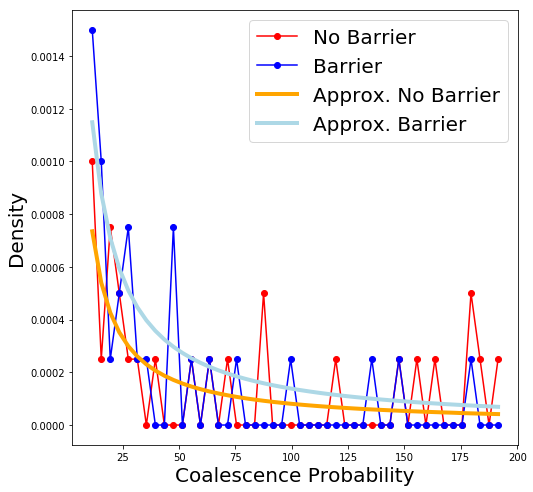

In [71]:
# Visualize Coalescence Times:
# Idea: Visualize Coalescence Times; as well as the approximation via 
# the pairwise likelihood:
# Maybe even make a picture depicting this:
# Visualize until the coalescence approximation becomes inaccurate.
x0=2.0
x1=2.0
nr = 1000 # The Number of Replicates
nr_b = 1000

t_min=10
t_max=200
bin_width=4
bins=np.array([t_min-0.5 + i*bin_width for i in xrange(int((t_max-t_min)/float(bin_width)))])

n, bins = np.histogram(coal_times, bins=bins) # Normed = True
n_b, bins_b = np.histogram(coal_times_bar, bins=bins)

# Normalize:
bin_width=(bins[1]-bins[0])
n = n/(float(nr) * bin_width)
n_b = n_b/(float(nr_b) * bin_width)

means = (bins[1:]+bins[:-1])/2.0

# Calculate the approximations:
approx = [coal_prob_ss(t=t, dy=0, x0=x0, x1=x1, k=1.0, D=1.0, De=5) for t in means]
approx_b= [coal_prob_ss(t=t, dy=0, x0=x0, x1=x1, k=0.01, D=1.0, De=5) for t in means]

plt.figure(figsize=(8,8))
plt.plot(means, n, "ro-", label="No Barrier")
plt.plot(means, n_b, "bo-", label="Barrier")

plt.plot(means, approx, label="Approx. No Barrier", color="Orange", linewidth=4)
plt.plot(means, approx_b, label="Approx. Barrier", color="LightBlue", linewidth=4)
plt.xlabel("Coalescence Probability", fontsize=20)
plt.ylabel("Density", fontsize=20)
plt.legend(fontsize=20)
plt.show()

# Make the big Picture
Introduce all the code to make the figure for the Paper. 
Then transfer it to Eclipse.

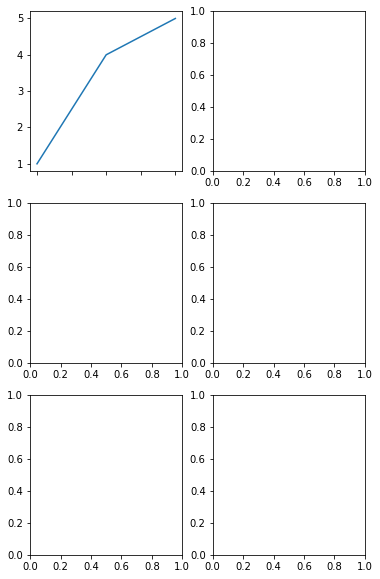

In [67]:
# Load all the simulated Data:
save_names_short = ["short_1717.csv", "short_1719", "short1919"]
save_names_long = ["long_1717.csv", "long_1719", "long_1919"]
save_names_short_barrier = ["short_barrier_1717.csv", "short_barrier_1719", "short_barrier_1919"]
save_names_long_barrier= ["long_barrier_1717.csv", "long_barrier_1719", "long_barrier_1919"]

path = data_folder + "short_1717.csv"
path_bar = data_folder + "short_barrier_1717.csv"

coal_times = np.loadtxt(path, dtype="int")
coal_times_bar = np.loadtxt(path_bar, dtype="int")

reps_short = 10000
reps_long = 100


# Do the Pre-Calculations:
x0=8.0
x1=8.0
nr = 10000 # The Number of Replicates
nr_replicates_long = 100 # The Number of the long Replicates

# Do the Binning:
approx = [coal_prob_ss(t=t, dy=0, x0=x0, x1=x1, k=1.0, D=1.0, De=5) for t in means]
approx_b= [coal_prob_ss(t=t, dy=0, x0=x0, x1=x1, k=0.01, D=1.0, De=5) for t in means]


# Short:
t_min=10
t_max=200
bin_width=4
bins=np.array([t_min-0.5 + i*bin_width for i in xrange(int((t_max-t_min)/float(bin_width)))])
means = (bins[1:]+bins[:-1])/2.0

# Long:
t_min_l=500
t_max_l=1000
bin_width_l=50
bins_l=np.array([t_min_l-0.5 + i*bin_width_l for i in xrange(int((t_max_l-t_min_l)/float(bin_width_l)))])
means = (bins_l[1:]+bins_l[:-1])/2.0

# Do the Histograms:
for i in xrange(3):
    n, bins = np.histogram(coal_times, bins=bins) # Normed = True
    n_b, bins_b = np.histogram(coal_times_bar, bins=bins)

# Do the analytical Approximations:
for i in xrange(3):
    


f, axes  = plt.subplots(3, 2, figsize=(9, 15)) # ((ax1, ax2), (ax3, ax4))
axes[0,0].plot([1,2,3],[1,4,5])
axes[0,0].xaxis.set_ticklabels([])

for i in xrange(3):
    '''Make the three Subfigures'''
    axes[0,0].xaxis.set_ticklabels([])
    
    # Load the Data
    
    # Calculate the 
    
    
    # Do the Plot

plt.show()